## Predict 

### DataSet - COCO + DeepFashion
COCO + DeepFashion으로 학습된 모델을 간단히 검증합니다.

### Val Generator
학습된 모델이 COCO dataset 포맷을 사용하므로, Val Generator도 COCO 것을 사용합니다.

In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.coco import CocoGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Model

모델을 Load합니다. 진행된 epoch에 따라 모델명이 다르므로 원하는 모델을 _snapshots_ 폴더 안에서 선택합니다.
pre train 모델을 다운받아야 합니다. 링크는 아래와 같습니다. https://github.com/fizyr/keras-retinanet/releases/download/0.1/resnet50_coco_best_v1.2.2.h5

In [69]:
model = keras.models.load_model('snapshots/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)
# model = keras.models.load_model('snapshots/resnet50_all_01.h5', custom_objects=custom_objects)

/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_2" during training.
  sample_weight_mode=sample_weight_mode)


## Create Val Generator

학습된 모델이 COCO dataset 포맷을 사용하므로, Val Generator도 COCO 것을 사용합니다.

In [70]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CocoGenerator(
    'dataset/all',
    'val2017',
    transform_generator=val_image_data_generator,
    batch_size=1,
)
index = 0

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


use train image -  dataset/all/images/val2017/000000252219.jpg
(428, 640, 3)
1.4018691588785046
[[326.28 174.56 397.52 371.81   0.  ]
 [  9.79 167.06 131.73 393.51   0.  ]
 [510.44 171.27 634.1  387.03   0.  ]
 [560.73  90.25 640.   157.57  25.  ]
 [ 46.01 211.11  79.56 262.96  26.  ]
 [345.13 226.41 356.19 248.55  41.  ]
 [337.06  44.11 398.42 101.28   9.  ]]
processing time:  4.666197061538696
scores [0.99634224 0.9818559  0.95827234 0.9458401  0.83606464 0.34148228
 0.25954455 0.23352493 0.23199621 0.22710061 0.19522122 0.16020966
 0.1539596  0.14942789 0.14121872 0.13282001 0.11556298 0.1140393
 0.0999207  0.09331208 0.0927764  0.08359598 0.08221141 0.07998993
 0.07981339 0.07714772 0.075883   0.07330466 0.07193234 0.07169849
 0.0716653  0.07142336 0.06854106 0.06710732 0.06649853 0.06306341
 0.0615608  0.05977601 0.05916458 0.05909295 0.05886113 0.05845284
 0.05822863 0.05647259 0.0562805  0.05501552 0.05470706 0.05451552
 0.05410856 0.05333479 0.0527702  0.0526649  0.05266361 0.0

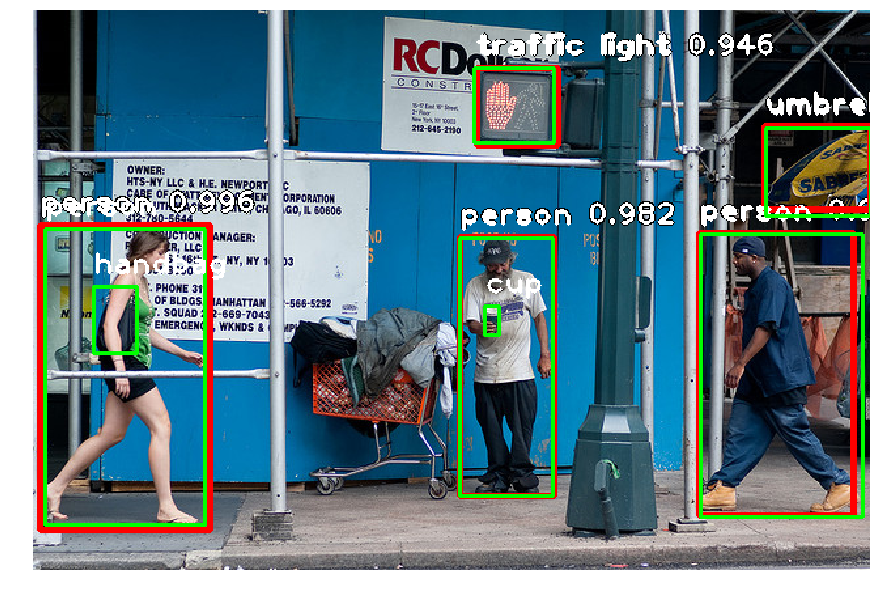

In [73]:
# load image
image = val_generator.load_image(index)
print(image.shape)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

print(scale)
print(annotations)

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
print('scores', scores)

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (255, 0, 0), 3)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    print('label', val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 2)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()